<a id="top"></a>
### **Supplement to _Characterising spatial structure in climate model ensembles_**

This notebook replicates the figures and analysis presented in _Characterising spatial structure in climate model ensembles_ (Chandler et al., 2022).

[EPP analysis of an unstructured ensemble, illustrated using the UKCP18 regional PPE](#unstructured-ensemble)
- [Figure 1: Change in frequency of wet days in UKCP18 ensemble members between 1980-2010 and 2050-2079](#figure-1)
- [Figure 2: Simple EPP analysis for an ensemble with no structure](#figure-2)

[EPP analysis of an unbalanced structured ensemble, illustrated using the EuroCORDEX regional MME](#structured-ensemble)
- [(i) Estimate the GCM and RCM effects](#fitted-model2)
- [(ii) Calculate the residual matrix](#model2-residuals)
- [(iii) Calculate the ranges of variation for the observed ensemble](#ranges-of-variation)
  - [Visualisation of range of variance explained within observed ensemble](#plot-range-of-varexp)
- [(iv) Estimated partitioning of uncertainty](#estimated-anova)
  - [Figure 3: Estimated partitioning of uncertainty](#figure-3)
- [(v) Calculate the EPPs of the fitted effects and, if appropriate, of the residuals](#gcm-epps)
  - [Figures 4 & 5: Estimated decomposition of variation in the EuroCORDEX ensemble](#figure-4&5)


In [1]:
# all modules & methods are provided in the epp_manova script
from epp_manova import *

<a id="unstructured-ensemble"></a>

---
### **Analysis of an unstructured ensemble**

<a id="figure-1"></a>
#### **Figure 1: change in frequency of wet days in UKCP18 ensemble members between 1980-2010 and 2050-2079** [^](#top)

Text(0.5, 1.0, 'Figure 1: Changes in percentage of wet summer days in the UKCP18 ensemble members between 1981-2010 and 2050-2079')

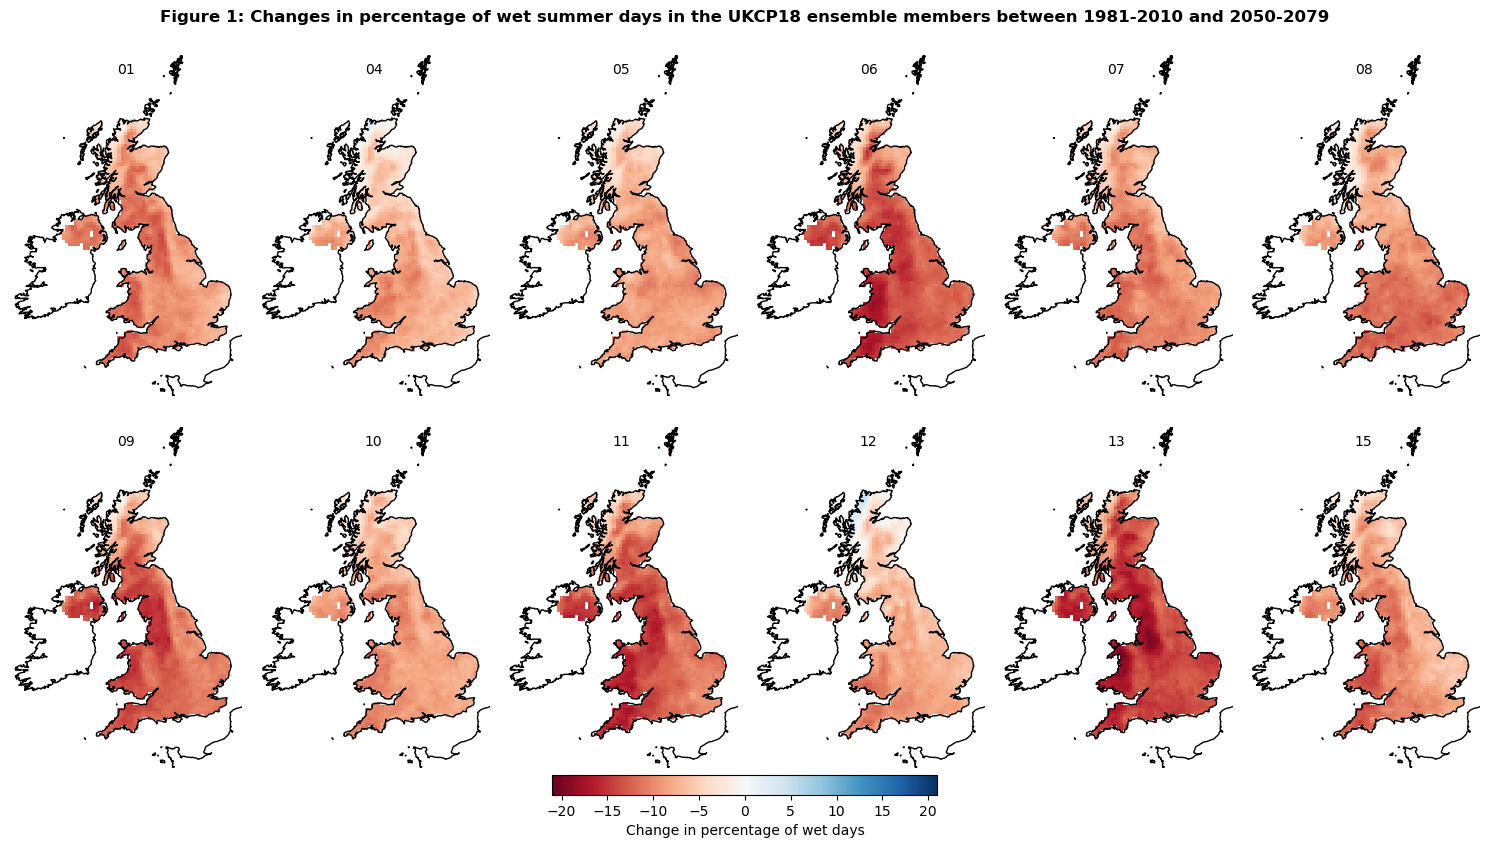

In [2]:
# load data
fwd = xr.open_dataset("fwd_JJA_2050-2079_ukcp18-12km.nc").fwd

# create array of subplots using OSGB projection, adjust spacing
fig, axs = plt.subplots(ncols = 6, nrows = 2, figsize = (15,8), sharex = True, sharey = True, dpi= 100, facecolor='w', edgecolor='k', subplot_kw = {"projection" : crs_osgb})
fig.tight_layout()
plt.subplots_adjust(hspace = 0)

# get extent of values for colourbar
vlim = np.ceil(max([np.abs(x) for x in [fwd.min(), fwd.max()]]))

# plot each ensemble member on separate axes
for i in range(12):
    
    ax = fig.axes[i]
    cbar = fwd.isel(run = i).plot(ax = ax, cmap = "RdBu", vmin = -vlim, vmax = vlim, add_colorbar = False)       # draw map
    
    ax.set_title(fwd.run.values[i], fontsize = "medium", y = 0.92)                                               # add title manually to customise height
    
    ax.set_extent((-2e5, 7e5, -1e5, 12.2e5), crs = crs_osgb)                                                     # fix plot extent to reduce whitespace
    ax.set_axis_off()                                                                                            # remove box around plot
    ax.coastlines()                                                                                              # draw coastlines
     
# add shared colourbar
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.01, label = "Change in percentage of wet days")

plt.suptitle("Figure 1: Changes in percentage of wet summer days in the UKCP18 ensemble members between 1981-2010 and 2050-2079", y = 1.0, fontweight = "bold")

<a id="figure-2"></a>
#### **Figure 2: Simple EPP analysis for an ensemble with no hierarchical structure** [^](#top)

When there is no structure in the ensemble, EPPs can be computed on the centred $n\times S$  data matrix $\widetilde{\textbf{Y}} = \textbf{Y} - \overline{\textbf{Y}}$.

Text(0.5, 1.1, 'Figure 2: EPPs analysis of the UKCP18 ensemble')

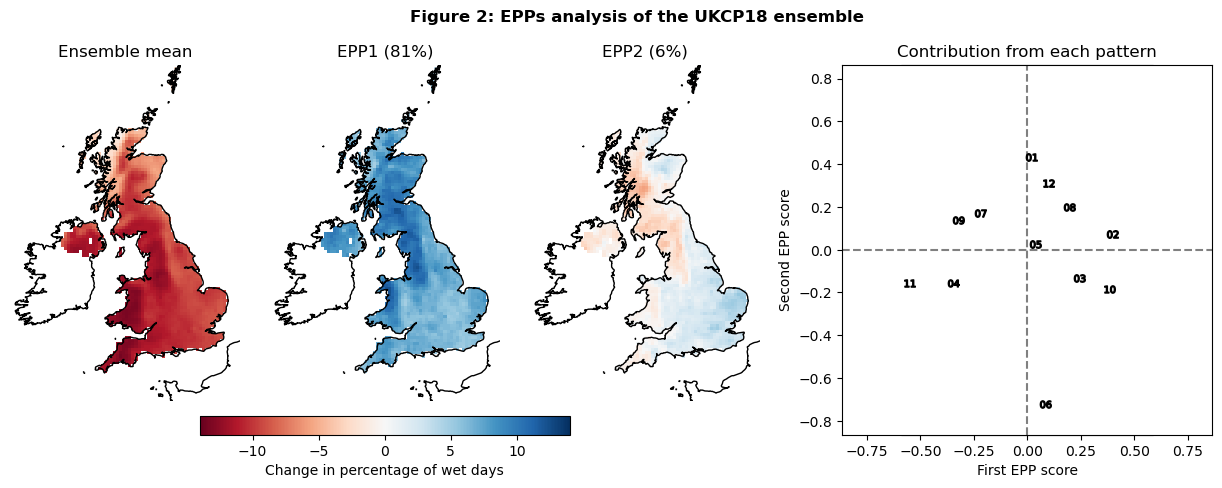

In [3]:
# load data
Y = xr.open_dataset("fwd_JJA_2050-2079_ukcp18-12km.nc").fwd

# centre the data by subtracting the ensemble mean at each location; flatten map array to vector
Ybar = Y.mean("run", skipna = False)
Y_tilde = (Y - Ybar).stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values

# compute EPPs on the centred data and plot
ukcp_epps = EPPs(Y_tilde, Ybar)
EPP_plot(*ukcp_epps.values(), cmap = "RdBu", markers = ["$"+str(i+1).rjust(2, "0")+"$" for i in range(12)], cbar_label = "Change in percentage of wet days")

plt.suptitle("Figure 2: EPPs analysis of the UKCP18 ensemble", y = 1.1, fontweight = "bold")

<a id="structured-ensemble"></a>

---
### **Analysis of an unbalanced structured ensemble** [^](#top)

<a id="fitted-model2"></a>

---
#### **(i) Fit GCM \& RCM effects by calculating least-squares estimates of the coefficients** [^](#top)

The least-squares coefficient estimates satisfy the equation
\begin{align}
(\textbf{X}' \textbf{X}) \left(\begin{matrix} \boldsymbol{\hat{\boldsymbol{\mu}}}' \\ \hat{\boldsymbol{\alpha}} \\ \hat{\boldsymbol{\beta}} \end{matrix} \right)= (\textbf{X}' \textbf{Y}),
\end{align}
where
$\textbf{X} = \left(\begin{matrix} \textbf{1} & \textbf{X}_G &\ \textbf{X}_R \end{matrix}\right)$, 
$\hat{\boldsymbol{\alpha}}$ and $\hat{\boldsymbol{\beta}}$ are, respectively, $(G-1) \times S$ and $(R-1) \times S$ matrices, and
$\textbf{Y}$ is the $n\times S$ ensemble data matrix.
Let $\hat{\boldsymbol{\theta}} = \left(\begin{matrix} \boldsymbol{\hat{\boldsymbol{\mu}}}' & \hat{\boldsymbol{\alpha}} & \hat{\boldsymbol{\beta}} \end{matrix} \right)'$: 
then we use a numerical solver to find $\hat{\boldsymbol{\theta}}$ such that $(\textbf{X}' \textbf{X}) \hat{\boldsymbol{\theta}} = (\textbf{X}' \textbf{Y})$.  
&nbsp;  

The coefficient estimation is completed by computing $\hat{\boldsymbol{\alpha}}_{G} = -\sum_{g=1}^{G-1}\hat{\boldsymbol{\alpha}}_{g}$ and $\hat{\boldsymbol{\beta}}_{R} = -\sum_{r=1}^{R-1}\hat{\boldsymbol{\beta}}_{r}$, to give a complete set of effect estimates for each GCM and RCM in the ensemble.  
The fitted effect matrices $\hat{\boldsymbol{\alpha}}$ and $\hat{\boldsymbol{\beta}}$ are therefore of size $G \times S$ and $R \times S$.

In [4]:
# Load the data
da = xr.open_dataset("tasmax_JJA_1989-2008_EuroCORDEX.nc").tasmax

# flatten DataArray and remove all NA values
Y = da.stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values

# get ensemble mean & standard deviation
Ybar = da.mean("run", skipna = False)
ens_sd = da.std("run", skipna = False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONSTRUCT DESIGN MATRICES

# identify GCM and RCM used for each run
run_names = da.run.values
run_gcm = da.run.str.replace("p1_.+","p1").values
run_rcm = da.run.str.replace(".+_","").values

# get G and R, counts of unique GCMs and RCMs
gcms = sorted(set(run_gcm))
rcms = sorted(set(run_rcm))

n = len(run_names)
G = len(gcms)
R = len(rcms)

# create matrices indicating group membership & stack to form X
X_G = np.column_stack([[-1 if gcms[-1] in run_name else (1 if g in run_name else 0) for run_name in run_names] for g in gcms[:-1]])
X_R = np.column_stack([[-1 if rcms[-1] in run_name else (1 if r in run_name else 0) for run_name in run_names] for r in rcms[:-1]])
X = np.column_stack([np.ones([n, 1]), X_G, X_R])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FIT MODEL 2

# solve equation (5) to find the fitted effects for model 2 (accounting for GCM and RCM simultaneously)
theta_hat = np.linalg.solve(X.transpose() @ X, X.transpose() @ Y)

# unpack the fitted coefficients and expand to obtain the Gth and Rth fitted effects
mu_hat = theta_hat[0,:]
alpha_hat = np.row_stack([theta_hat[1:G,:], -theta_hat[1:G,:].sum(0)])
beta_hat = np.row_stack([theta_hat[G:,:], -theta_hat[G:,:].sum(0)])

<a id="model2-residuals"></a>

#### **(ii) Calculate the residual matrix** [^](#top)

The residuals from the fitted model are the $n\times S$ matrix
$$\boldsymbol{e}^{(2)} = \textbf{Y}- \textbf{1}\hat{\boldsymbol{\mu}}' - \textbf{X}_G \hat{\boldsymbol{\alpha}} - \textbf{X}_R \hat{\boldsymbol{\beta}} = \textbf{Y}-\textbf{X}\hat{\boldsymbol{\theta}}.$$

In [5]:
# compute residuals
e_2 = Y - (X @ theta_hat)
T_res = e_2.transpose() @ e_2

<a id="estimated-anova"></a>

#### **(iv) Estimated partitioning of uncertainty in the completed ensemble** [^](#top)

We can now use the fitted effects $\hat{\boldsymbol{\alpha}}$ and $\hat{\boldsymbol{\beta}}$ and the residuals $\textbf{e}^{(2)}$ to estimate the partitioned sums of squares in the completed ensemble:
\begin{align}
\boldsymbol{T}_G^\dagger = R \sum_{g=1}^G \hat{\boldsymbol{\alpha}}_g \hat{\boldsymbol{\alpha}}_g'
&&
\boldsymbol{T}_R^\dagger = G \sum_{r=1}^R \hat{\boldsymbol{\beta}}_r \hat{\boldsymbol{\beta}}_r'
&&
\boldsymbol{T}_E^\dagger = (G-1)(R-1) \hat{\boldsymbol{\Sigma}}
&& &&
\boldsymbol{T}^\dagger = \boldsymbol{T}_G^\dagger + \boldsymbol{T}_R^\dagger +\boldsymbol{T}_E^\dagger
\end{align}

where $\hat{\boldsymbol{\Sigma}} = {\boldsymbol{e}^{(2)}}'\boldsymbol{e}^{(2)} \big/ (n-R-G-1)$ is the unbiased estimator  of the residual covariance matrix $\boldsymbol{\Sigma}$.

In [6]:
# estimate SSCPs for 'completed' emsemble using reweighted fitted effects & residuals
Tc_G2 = R * alpha_hat.transpose() @ alpha_hat
Tc_R2 = G * beta_hat.transpose() @ beta_hat
Tc_res = (R-1) * (G-1) * T_res / (n - R - G - 1)
Tc = Tc_G2 + Tc_R2 + Tc_res

# get maps of contribution per grid cell
est_ve_maps = {k : reshape_to_map(np.diag(eval(k) / Tc * 100), Ybar) for k in ["Tc_G2", "Tc_R2", "Tc_res"]}

# compute ranges of proportion of variance in the observed ensemble explained by each model
est_ve = {k : np.trace(eval(k)) / np.trace(Tc) * 100 for k in ["Tc_G2", "Tc_R2", "Tc_res"]}
est_ve_string = ["\n("+str(int(v))+"%)" for v in est_ve.values()]

<a id="figure-3"></a>
##### **Figure 3: Estimated decomposition of variation in the EuroCORDEX ensemble** [^](#top)

Text(0.5, 1.03, 'Figure 3: Estimated decomposition of variation in the EuroCORDEX ensemble')

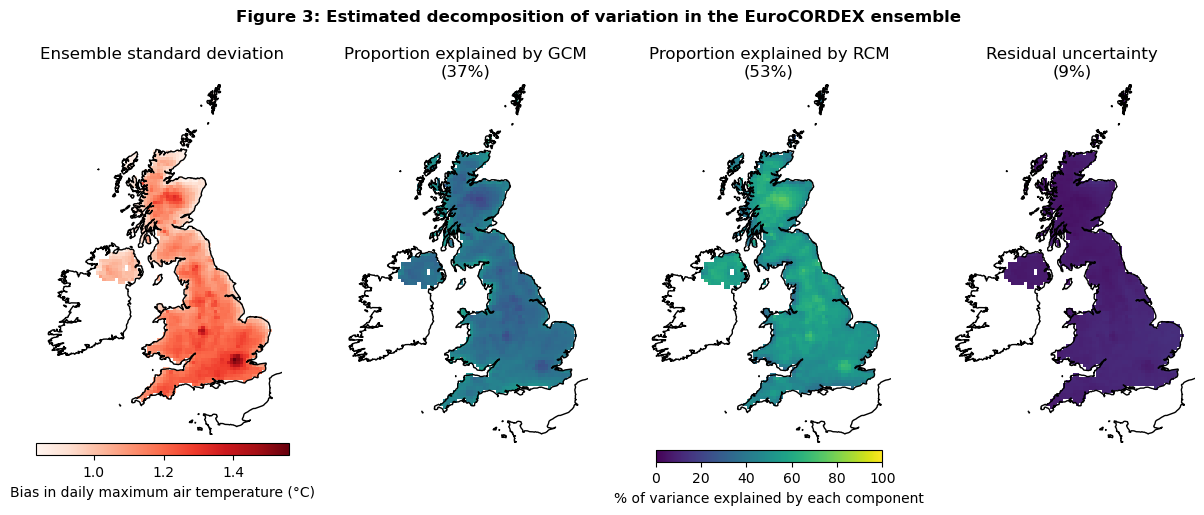

In [7]:
# create array of subplots using OSGB projection, adjust spacing
fig, axs = plt.subplots(ncols = 4, figsize = (15,5), sharex = True, sharey = True, dpi= 100, facecolor='w', edgecolor='k', subplot_kw = {"projection" : crs_osgb})
plt.subplots_adjust(hspace = 0)

# set spatial extent of map axes, remove bounding box, add coastlines
for ax in fig.axes:
    ax.set_extent((-2e5, 7e5, -1e5, 12.2e5), crs = crs_osgb)                                                       # fix plot extent to reduce whitespace
    ax.set_axis_off()                                                                                              # remove box around plot
    ax.coastlines()                                                                                                # draw coastlines
    
cbar_ss = ens_sd.plot(ax = axs[0], cmap = "Reds", add_colorbar = False)
axs[0].set_title("Ensemble standard deviation\n")
    
for i in range(3):
    cbar_ve = list(est_ve_maps.values())[i].plot(ax = axs[i+1], vmin = 0, vmax = 100, add_colorbar = False, cmap = "viridis")
    titlestring = ["Proportion explained by GCM", "Proportion explained by RCM", "Residual uncertainty"][i] + est_ve_string[i]
    axs[i+1].set_title(titlestring)

plt.colorbar(cbar_ss, ax = axs[0], location = "bottom", pad = 0.02, fraction = 0.05, label ="Bias in daily maximum air temperature (°C)")
plt.colorbar(cbar_ve, ax = axs[1:], location = "bottom", pad = 0.02, fraction = 0.03, label = "% of variance explained by each component")

plt.suptitle("Figure 3: Estimated decomposition of variation in the EuroCORDEX ensemble", y = 1.03, fontweight = "bold")

<a id="gcm-epps"></a>

#### **(v) Calculate EPPs of fitted GCM & RCM effects** [^](#top)



In [8]:
# compute EPPs from fitted effects
gcm_epps = EPPs(alpha_hat, Ybar)
rcm_epps = EPPs(beta_hat, Ybar)
residual_epps = EPPs(e_2, Ybar)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# specify plotting symbols & colours to reflect those used in the paper
gcm_markers = {'CNRM-CERFACS-CNRM-CM5_r1i1p1': 'o', 'ICHEC-EC-EARTH_r12i1p1': 'p', 'ICHEC-EC-EARTH_r1i1p1': 'h', 'ICHEC-EC-EARTH_r3i1p1': 'H', 'IPSL-IPSL-CM5A-MR_r1i1p1': 's',
               'MOHC-HadGEM2-ES_r1i1p1': 'P', 'MPI-M-MPI-ESM-LR_r1i1p1': '<', 'MPI-M-MPI-ESM-LR_r2i1p1': '^', 'MPI-M-MPI-ESM-LR_r3i1p1': '>', 'NCC-NorESM1-M_r1i1p1': 'X'}

rcm_colours = {'ALADIN63': 'mediumblue', 'CCLM4-8-17': 'blueviolet', 'COSMO-crCLIM-v1-1': 'mediumvioletred', 'HIRHAM5': 'red', 'HadREM3-GA7-05': 'darkorange', 'RACMO22E': 'gold',
               'RCA4': 'yellowgreen', 'REMO2015': 'green', 'RegCM4-6': 'darkturquoise', 'WRF381P': 'dodgerblue'}

# get maximum values to fix colour scale & score axes for both GCMs and RCMs
vmax = max([np.abs(epps["EPPs"].max()) for epps in [gcm_epps, rcm_epps, residual_epps]] + [np.abs(epps["EPPs"].min()) for epps in [gcm_epps, rcm_epps, residual_epps]])
smax = max([np.abs(epps["scores"].max()) for epps in [gcm_epps, rcm_epps, residual_epps]] + [np.abs(epps["scores"].min()) for epps in [gcm_epps, rcm_epps, residual_epps]]) * 1.2

<a id="figure-4&5"></a>
##### **Figures 4 & 5: Estimated decomposition of variation in the EuroCORDEX ensemble**

Text(0.5, 1.1, 'EPPs of residuals')

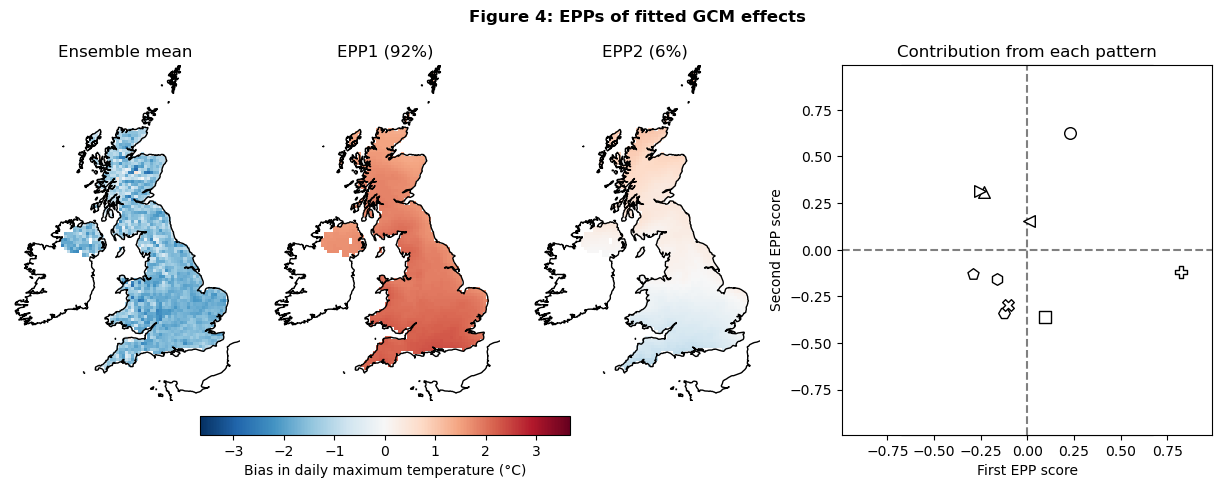

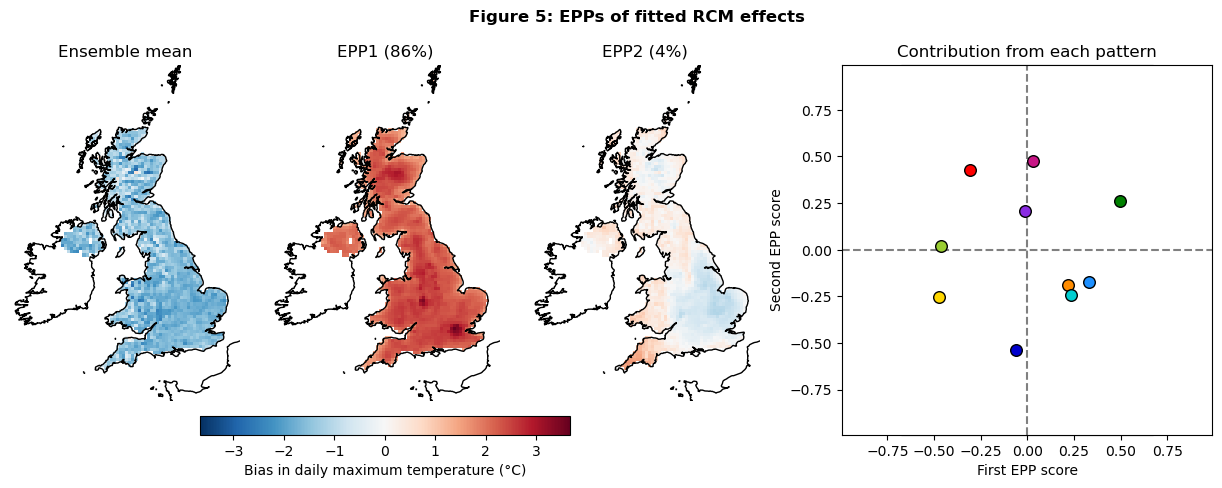

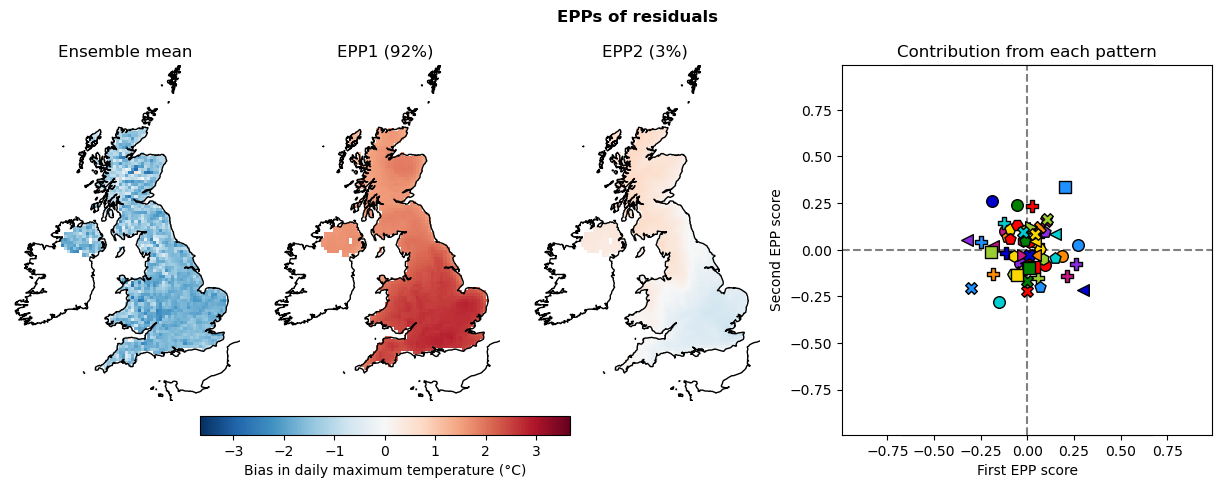

In [9]:
# plot GCM EPPs
EPP_plot(*gcm_epps.values(), cmap = "RdBu_r", markers = list(gcm_markers.values()), colours = "w", cbar_label = "Bias in daily maximum temperature (°C)", vlim = vmax)
plt.gca().set_xlim(-smax, smax); plt.gca().set_ylim(-smax, smax)
plt.suptitle("Figure 4: EPPs of fitted GCM effects", y = 1.1, fontweight = "bold")

# plot RCM EPPs
EPP_plot(*rcm_epps.values(), cmap = "RdBu_r", colours = list(rcm_colours.values()), cbar_label = "Bias in daily maximum temperature (°C)", vlim = vmax)
plt.gca().set_xlim(-smax, smax); plt.gca().set_ylim(-smax, smax)
plt.suptitle("Figure 5: EPPs of fitted RCM effects", y = 1.1, fontweight = "bold")

# plot residual EPPs
EPP_plot(*residual_epps.values(), cmap = "RdBu_r", cbar_label = "Bias in daily maximum temperature (°C)", vlim = vmax,
        markers = [gcm_markers[re.sub("p1_.+", "p1", g)] for g in run_names],
        colours = [rcm_colours[re.sub(".+p1_", "", r)] for r in run_names])
plt.gca().set_xlim(-smax, smax); plt.gca().set_ylim(-smax, smax)
plt.suptitle("EPPs of residuals", y = 1.1, fontweight = "bold")

<a id="ranges-of-variation"></a>

#### **(iii) Calculate ranges of variation in the observed ensemble** [^](#top)


Ranges of variation ascribed to each of the effects in the observed ensemble are obtained by fitting models in order of increasing complexity:

\begin{align}
\textbf{Model 0:} 
  && \boldsymbol{Y} &= \boldsymbol{\mu} + \boldsymbol{\varepsilon_{rg}} 
  && \text{with} 
  && \hat{\boldsymbol{\mu}}^{(1a)} = \overline{\boldsymbol{Y}}
\\
\textbf{Model 1a:} 
  && \boldsymbol{Y} &= \boldsymbol{\mu} + \boldsymbol{\alpha}_g + \boldsymbol{\varepsilon_{rg}} 
  && \text{with} 
  && \hat{\boldsymbol{\mu}}^{(1a)} = \overline{\boldsymbol{Y}}
  && \text{and} 
  && \hat{\boldsymbol{\alpha}}_g^{(1a)} = \overline{\boldsymbol{Y}}_{\cdot g} - \overline{\boldsymbol{Y}}_{\cdot \cdot}
\\
\textbf{Model 1b:} 
  && \boldsymbol{Y} &= \boldsymbol{\mu} + \boldsymbol{\beta}_r + \boldsymbol{\varepsilon_{rg}} 
  && \text{with} 
  && \hat{\boldsymbol{\mu}}^{(1b)} = \overline{\boldsymbol{Y}}
  && \text{and} 
  && \hat{\boldsymbol{\beta}}_r^{(1b)} = \overline{\boldsymbol{Y}}_{r \cdot} - \overline{\boldsymbol{Y}}_{\cdot \cdot}
\\
\textbf{Model 2:} 
  && \boldsymbol{Y} &= \boldsymbol{\mu} + \boldsymbol{\alpha}_g + \boldsymbol{\beta}_r + \boldsymbol{\varepsilon_{rg}} 
  && \text{with} 
  && \hat{\boldsymbol{\mu}}^{(1b)} = \overline{\boldsymbol{Y}}
  && \text{and} 
  && \hat{\boldsymbol{\beta}}_r^{(1b)} = \overline{\boldsymbol{Y}}_{r \cdot} - \overline{\boldsymbol{Y}}_{\cdot \cdot}
\end{align}


Residuals from sequences of fitted models are used to partition the SSCPs in the observed ensemble:
\begin{align}
\text{ Model 0 } \rightarrow \text{ Model 1a } \rightarrow \text{ Model 2: } 
  && \boldsymbol{T} = \boldsymbol{T}_G^{(a)} + \boldsymbol{T}_R^{(a)} + \boldsymbol{T}_E
\end{align}

In [10]:
# observed TSS
e_0 = (da - Ybar).stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values
T_obs = e_0.transpose() @ e_0
TSS = np.trace(T_obs)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# fitted GCM and RCM effects for models 1a & 1b
alphahat_1a = da.groupby(da.run.str.replace("p1_.+", "p1")).mean() - Ybar
betahat_1b = da.groupby(da.run.str.replace(".+p1_", "")).mean() - Ybar

# fitted values for models 1a & 1b
fitted_1a = Ybar + alphahat_1a.reindex(run = da.run.str.replace("p1_.+", "p1")).assign_coords(run = da.run.values)
fitted_1b = Ybar + betahat_1b.reindex(run = da.run.str.replace(".+p1_", "")).assign_coords(run = da.run.values)

# residual matrices for models 1a & 1b
e_1a = (da - fitted_1a).stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values
e_1b = (da - fitted_1b).stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# compute the partitioned variance for each model

T_Ga = (e_0.transpose() @ e_0) - (e_1a.transpose() @ e_1a)
T_Ra = (e_1a.transpose() @ e_1a) - (e_2.transpose() @ e_2)

T_Rb = (e_0.transpose() @ e_0) - (e_1b.transpose() @ e_1b)
T_Gb = (e_1b.transpose() @ e_1b) - (e_2.transpose() @ e_2)

T_G2 = (X_G @ alpha_hat[:-1,:]).transpose() @ (X_G @ alpha_hat[:-1,:])
T_R2 = (X_R @ beta_hat[:-1,:]).transpose() @ (X_R @ beta_hat[:-1,:])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# reshape diagonals of SSCPs to maps
obs_ve_maps = {k : reshape_to_map(np.diag(eval(k) / T_obs * 100), to_map = Ybar) for k in ["T_Ga", "T_Ra", "T_Gb", "T_Rb", "T_G2", "T_R2", "T_res"]}

# compute ranges of proportion of variance in the observed ensemble explained by each model
obs_ve = {k : np.trace(eval(k)) / TSS * 100 for k in obs_ve_maps.keys()}

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# optional: estimated variance explained by models 1a and 1b in the completed ensemble
ah_1a = alphahat_1a.stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values
bh_1b = betahat_1b.stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values


<a id='plot-range-of-varexp'></a>
#### **Visualisation of ranges of variance explained** [^](#top)

Text(0.5, 0.98, 'MANOVA in unbalanced ensemble')

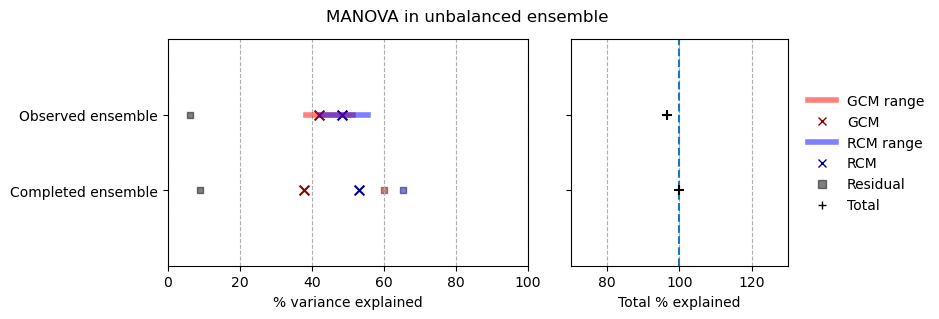

In [12]:
# plot of proportion of variance explained

fig, axs = plt.subplots(ncols = 2, figsize = (8,3), dpi = 100, facecolor = "w", sharey = True, gridspec_kw = {'width_ratios' : [1, 0.6]})
plt.subplots_adjust(wspace = 0.15)
axs[0].grid(axis = "x", ls = "--", zorder = -99); axs[1].grid(axis = "x", ls = "--")

#~~~~~~~~~~~~~~~~~~~~~~~~~~

axs[0].plot((obs_ve["T_Ga"], obs_ve["T_Gb"]), (0,0), lw = 4, color = "red", alpha = 0.5)
axs[0].plot((obs_ve["T_Ra"], obs_ve["T_Rb"]), (0,0), lw = 4, color = "blue", alpha = 0.5)
axs[0].scatter(obs_ve["T_G2"], 0, color = "darkred", marker = "x", s = 50)
axs[0].scatter(obs_ve["T_R2"], 0, color = "darkblue", marker = "x", s = 50)
axs[0].scatter(obs_ve["T_res"], 0, marker = "s", s = 20, color = "black", alpha = 0.5)
axs[0].scatter(est_ve["Tc_G2"], -1, color = "darkred", marker = "x", s = 50)
axs[0].scatter(est_ve["Tc_R2"], -1, color = "darkblue", marker = "x", s = 50)
axs[0].scatter(est_ve["Tc_res"], -1, marker = "s", s = 20, color = "black", alpha = 0.5)

axs[0].scatter(R * np.trace(ah_1a.transpose() @ ah_1a) / np.trace(Tc) * 100, -1, marker = "s", s = 20, color = "darkred", alpha = 0.5)
axs[0].scatter(G * np.trace(bh_1b.transpose() @ bh_1b) / np.trace(Tc) * 100, -1, marker = "s", s = 20, color = "darkblue", alpha = 0.5)

axs[0].set_ylim(-2,1); axs[0].set_yticks([0,-1]); axs[0].set_yticklabels(["Observed ensemble", "Completed ensemble"])
axs[0].set_xlim(0,100,10)

#~~~~~~~~~~~~~~~~~~~~~~~~~~

axs[1].scatter(sum([obs_ve[v] for v in ["T_G2", "T_R2", "T_res"]]), 0, marker = "+", s = 50, color = "black")
axs[1].scatter(sum([est_ve[v] for v in ["Tc_G2", "Tc_R2", "Tc_res"]]), -1, marker = "+", s = 50, color = "black", zorder = 99)
axs[1].plot((sum([obs_ve[v] for v in ["T_Ga", "T_Ra", "T_res"]]), sum([obs_ve[v] for v in ["T_Gb", "T_Rb", "T_res"]])), (0,0), lw = 4, color = "red", alpha = 0.5)

axs[1].set_xlim(70,130)
axs[1].axvline(100, ls = "--")

#~~~~~~~~~~~~~~~~~~~~~~~~~~
# add legend & axis labels

legend = {"GCM range" : matplotlib.lines.Line2D([], [], lw = 4, color = "red", alpha = 0.5),
          "GCM" : matplotlib.lines.Line2D([], [], color = "darkred", ls = "", marker = "x"),
          "RCM range" : matplotlib.lines.Line2D([], [], lw = 4, color = "blue", alpha = 0.5),
          "RCM" : matplotlib.lines.Line2D([], [], color = "darkblue", ls = "", marker = "x"),
          "Residual" : matplotlib.lines.Line2D([], [], color = "black", alpha = 0.5, ls = "", marker = "s"),
          "Total" : matplotlib.lines.Line2D([], [], color = "black", ls = "", marker = "+"),
         }
fig.legend(handles = legend.values(), labels = legend.keys(), edgecolor = "w", loc = 'center left', bbox_to_anchor = (0.91, 0.5))

axs[0].set_xlabel("% variance explained")
axs[1].set_xlabel("Total % explained")

fig.suptitle("MANOVA in unbalanced ensemble")

---
---
&nbsp;  
### **The odd bit: if we solve equation (5) to fit models 1a and 1b, why do we not get the expected fitted effects?** [^](#top)

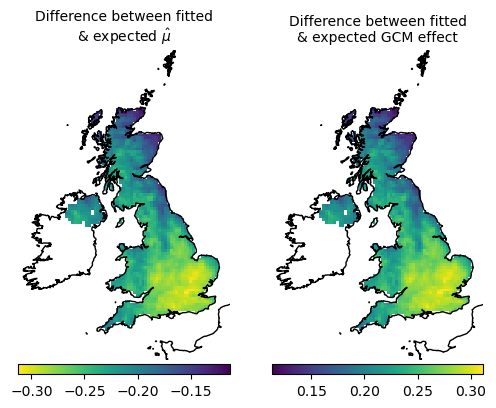

In [13]:
thetahat_1a_ls, thetahat_1b_ls = [np.linalg.solve(X.transpose() @ X, X.transpose() @ Y) for X in [np.column_stack([np.ones([n, 1]), X_G]),
                                                                                                  np.column_stack([np.ones([n, 1]), X_R])]]
muhat_1a_ls = reshape_to_map(thetahat_1a_ls[0,:], Ybar)
alphahat_1a_ls = reshape_to_map(np.row_stack([thetahat_1a_ls[1:,:], -thetahat_1a_ls[1:,:].sum(0)]), Ybar, {"run" : gcms})
fitted_1a_ls = (alphahat_1a_ls + muhat_1a_ls).reindex(run = da.run.str.replace("p1_.+", "p1")).assign_coords(run = da.run.values)

T_muhat = ((muhat_1a_ls - Ybar)**2) * len(run_names)
T_fitted = ((fitted_1a_ls - Ybar)**2).sum("run", skipna = False)
T_alpha = T_fitted - T_muhat
T_res = ((da - Ybar)**2).sum("run", skipna = False) - T_fitted


# check that offset is same for all runs
(np.abs((alphahat_1a_ls - alphahat_1a).max("run") - (alphahat_1a_ls - alphahat_1a).min("run")).round(10).max() == 0)

# and that offset is the negative of the mu_hat offset
np.abs((alphahat_1a_ls - alphahat_1a).max("run") - (Ybar - muhat_1a_ls)).round(10).max() == 0

from plotting import *

# plot difference between fitted & expected effects with inverted colour scales
fig, axs = ukmap_subplots(ncols = 2)
qmap(muhat_1a_ls - Ybar, ax = axs[0], cmap = "viridis_r", title = "Difference between fitted\n& expected $\hat{\mu}$")
qmap((alphahat_1a_ls - alphahat_1a).isel(run = 0), ax = axs[1], cmap = "viridis", title = "Difference between fitted\n& expected GCM effect")